In [1]:
import numpy as np
import pandas as pd
import spacy
import string
import pickle as pkl
from sklearn import preprocessing
import os.path
from operator import add

In [2]:
#load in the data
train_df = pd.read_csv('snli_train.tsv', sep="\t")
val_df = pd.read_csv('snli_val.tsv',sep="\t")

#get data & convert sentences to lists
train_sentence1=train_df['sentence1'].values.tolist()
train_sentence2=train_df['sentence2'].values.tolist()
val_sentence1=val_df['sentence1'].values.tolist()
val_sentence2=val_df['sentence2'].values.tolist()

#convert the text labels to numeric
le = preprocessing.LabelEncoder()
le.fit(train_df['label'])
train_targets=le.transform(train_df['label']).tolist()
val_targets=le.transform(val_df['label']).tolist()

In [3]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]

In [4]:
# This is the code cell that tokenizes train/val/test datasets
def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [5]:
#train set tokens
if not os.path.exists('train_all_combined_sentence_tokens.p'):
    print("Tokenizing train data")
    train_sentence1_tokens, train_all_sentence1_tokens = tokenize_dataset(train_sentence1)
    train_sentence2_tokens, train_all_sentence2_tokens = tokenize_dataset(train_sentence2)
    train_all_combined_sentence_tokens = train_all_sentence1_tokens + train_all_sentence2_tokens
    pkl.dump(train_all_combined_sentence_tokens, open("train_all_combined_sentence_tokens.p", "wb"))

In [6]:
#if pickle files do not exist, collect them.  Otherwise, this if block will not run
if not os.path.exists('train_sentence1_tokens.p'):
    print ("Tokenizing train data")
    train_sentence1_tokens, train_all_sentence1_tokens = tokenize_dataset(train_sentence1)
    train_sentence2_tokens, train_all_sentence2_tokens = tokenize_dataset(train_sentence2)
    pkl.dump(train_sentence1_tokens, open("train_sentence1_tokens.p", "wb"))
    pkl.dump(train_sentence2_tokens, open("train_sentence2_tokens.p", "wb"))
    #pkl.dump(train_all_sentence1_tokens, open("train_all_sentence1_tokens.p", "wb"))
    #pkl.dump(train_all_sentence2_tokens, open("train_all_sentence2_tokens.p", "wb"))1

    #combine tokens from both sentences to create a shared dictionary
    train_all_combined_sentence_tokens = train_all_sentence1_tokens + train_all_sentence2_tokens
    pkl.dump(train_all_combined_sentence_tokens, open("train_all_combined_sentence_tokens.p", "wb"))

    #val set tokens
    print ("Tokenizing val data")
    val_sentence1_tokens, _ = tokenize_dataset(val_sentence1)
    val_sentence2_tokens, _ = tokenize_dataset(val_sentence2)
    pkl.dump(val_sentence1_tokens, open("val_sentence1_tokens.p", "wb"))
    pkl.dump(val_sentence2_tokens, open("val_sentence2_tokens.p", "wb"))

In [7]:
#If you have previously run the previous cell, run this cell instead to load preprocessed datasets
train_sentence1_tokens = pkl.load(open("train_sentence1_tokens.p", "rb"))
train_sentence2_tokens = pkl.load(open("train_sentence2_tokens.p", "rb"))
train_all_combined_sentence_tokens = pkl.load(open("train_all_combined_sentence_tokens.p", "rb"))
train_all_sentence1_tokens = pkl.load(open("train_all_sentence1_tokens.p", "rb"))
train_all_sentence2_tokens = pkl.load(open("train_all_sentence2_tokens.p", "rb"))
val_sentence1_tokens = pkl.load(open("val_sentence1_tokens.p", "rb"))
val_sentence2_tokens = pkl.load(open("val_sentence2_tokens.p", "rb"))

In [8]:
#print information about the token datasets
# double checking
print ("Train sentence1 dataset size is {}".format(len(train_sentence1_tokens)))
print ("Train sentence2 dataset size is {}".format(len(train_sentence2_tokens)))
print ("Val sentence1 dataset size is {}".format(len(val_sentence1_tokens)))
print ("Val sentence2 dataset size is {}".format(len(val_sentence2_tokens)))

print ("\nTotal number of tokens in sentence1 train dataset is {}".format(len(train_all_sentence1_tokens)))
print ("Total number of tokens in sentence2 train dataset is {}".format(len(train_all_sentence2_tokens)))
print ("Total number of tokens in combined sent1 & sent2 train dataset is {}".format(len(train_all_combined_sentence_tokens)))

print ("\nTotal number of *unique* tokens in sentence1 train dataset is {}".format(len(set(train_all_sentence1_tokens))))
print ("Total number of *unique* tokens in sentence2 train dataset is {}".format(len(set(train_all_sentence2_tokens))))
print ("Total number of *unique* tokens in sent1 & sent2 train dataset is {}".format(len(set(train_all_combined_sentence_tokens))))


Train sentence1 dataset size is 100000
Train sentence2 dataset size is 100000
Val sentence1 dataset size is 1000
Val sentence2 dataset size is 1000

Total number of tokens in sentence1 train dataset is 1294135
Total number of tokens in sentence2 train dataset is 743372
Total number of tokens in combined sent1 & sent2 train dataset is 2037507

Total number of *unique* tokens in sentence1 train dataset is 14131
Total number of *unique* tokens in sentence2 train dataset is 15225
Total number of *unique* tokens in sent1 & sent2 train dataset is 19642


In [9]:
#build vocabularies for sentence1 and sentence2
from collections import Counter

#max_vocab_size = 10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

#try different vocab sizes
vocab1=10000
vocab2=15000
#vocab3=19000
token2id_combined_sent, id2token_combined_sent = build_vocab(train_all_combined_sentence_tokens,vocab1)
token2id_combined_sent_voc2, id2token_combined_sentvoc2 = build_vocab(train_all_combined_sentence_tokens,vocab2)
#token2id_combined_sent_voc3, id2token_combined_sentvoc3 = build_vocab(train_all_combined_sentence_tokens,vocab3)

In [10]:
# Lets check the dictionary by loading random token from it
import random 

random_token_id = random.randint(0, len(id2token_combined_sent)-1)
random_token = id2token_combined_sent[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token_combined_sent[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id_combined_sent[random_token]))

Token id 8817 ; token lily
Token lily; token id 8817


In [11]:
# convert token to id in the dataset.  After running this cell we will have converted the word tokens to indices
def token2index_dataset(tokens_data,token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

#create train & val for vocab1 size
train_sentence1_data_indices = token2index_dataset(train_sentence1_tokens,token2id_combined_sent)
train_sentence2_data_indices = token2index_dataset(train_sentence2_tokens,token2id_combined_sent)
val_sentence1_data_indices = token2index_dataset(val_sentence1_tokens,token2id_combined_sent)
val_sentence2_data_indices = token2index_dataset(val_sentence2_tokens,token2id_combined_sent)

#create train & val for vocab2 size
train_sentence1_data_indices_voc2 = token2index_dataset(train_sentence1_tokens,token2id_combined_sent_voc2)
train_sentence2_data_indices_voc2 = token2index_dataset(train_sentence2_tokens,token2id_combined_sent_voc2)
val_sentence1_data_indices_voc2 = token2index_dataset(val_sentence1_tokens,token2id_combined_sent_voc2)
val_sentence2_data_indices_voc2 = token2index_dataset(val_sentence2_tokens,token2id_combined_sent_voc2)

#create train & val for vocab3 size
# train_sentence1_data_indices_voc3 = token2index_dataset(train_sentence1_tokens,token2id_combined_sent_voc3)
# train_sentence2_data_indices_voc3 = token2index_dataset(train_sentence2_tokens,token2id_combined_sent_voc3)
# val_sentence1_data_indices_voc3 = token2index_dataset(val_sentence1_tokens,token2id_combined_sent_voc3)
# val_sentence2_data_indices_voc3 = token2index_dataset(val_sentence2_tokens,token2id_combined_sent_voc3)

# double checking
print ("Train sentence1 dataset size is {}".format(len(train_sentence1_data_indices)))
print ("Train sentence2 dataset size is {}".format(len(train_sentence2_data_indices)))
print ("Val sentence1 dataset size is {}".format(len(val_sentence1_data_indices)))
print ("Val sentence2 dataset size is {}".format(len(val_sentence2_data_indices)))

Train sentence1 dataset size is 100000
Train sentence2 dataset size is 100000
Val sentence1 dataset size is 1000
Val sentence2 dataset size is 1000


In [12]:
#visualize a random sentence1 and sentence2 paired training example
rand_training_example = random.randint(0, len(train_sentence1) - 1)
print (train_sentence1_tokens[rand_training_example])
print(train_sentence1_data_indices[rand_training_example])

print (train_sentence2_tokens[rand_training_example])
print(train_sentence2_data_indices[rand_training_example])

['a', 'man', 'and', 'a', 'woman', 'are', 'outside', 'kissing', 'with', 'a', 'woman', 'wearing', 'a', 'red', 'scarf', 'in', 'the', 'background']
[2, 6, 8, 2, 12, 9, 38, 749, 11, 2, 12, 17, 2, 34, 576, 4, 3, 99]
['a', 'man', 'and', 'an', 'ugly', 'woman', 'are', 'outside', 'kissing']
[2, 6, 8, 18, 4034, 12, 9, 38, 749]


In [13]:
#Check average, max, min sentence lengths to determine word padding
total_sent1_len=0
total_sent2_len=0
sent1_lens=[]
sent2_lens=[]
for i in range(0,len(train_sentence1_tokens)):
    total_sent1_len+=len(train_sentence1_tokens[i])
    total_sent2_len+=len(train_sentence2_tokens[i])
    sent1_lens.append(len(train_sentence1_tokens[i]))
    sent2_lens.append(len(train_sentence2_tokens[i]))

avg1=total_sent1_len/len(train_sentence1)
avg2=total_sent2_len/len(train_sentence2)
print("sentence1 average is: "+str(avg1)+", std dev is: "+str(np.std(sent1_lens))+", max is: "+str(max(sent1_lens))+", min is: "+str(min(sent1_lens)))
print("sentence2 average is: "+str(avg2)+", std dev is: "+str(np.std(sent2_lens))+", max is: "+str(max(sent2_lens))+", min is: "+str(min(sent2_lens)))


sentence1 average is: 12.94135, std dev is: 5.755700667816214, max is: 78, min is: 2
sentence2 average is: 7.43372, std dev is: 3.0907033118046123, max is: 38, min is: 1


In [14]:
import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list1, data_list2, target_list, MAX_SENTENCE_LENGTH):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list1 = data_list1
        self.data_list2 = data_list2
        self.MAX_SENTENCE_LENGTH=MAX_SENTENCE_LENGTH
        self.target_list = target_list
        assert (len(self.data_list1) == len(self.target_list) == len(self.data_list2))

    def __len__(self):
        return len(self.data_list1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_idx1 = self.data_list1[key][:self.MAX_SENTENCE_LENGTH]
        token_idx2 = self.data_list2[key][:self.MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        
        return [token_idx1, token_idx2, len(token_idx1), len(token_idx2), label]
    

In [15]:
train_dataset = NewsGroupDataset(train_sentence1_data_indices,train_sentence2_data_indices, train_targets, 35)
val_dataset = NewsGroupDataset(val_sentence1_data_indices, val_sentence2_data_indices, val_targets, 35)

train_dataset_voc2 = NewsGroupDataset(train_sentence1_data_indices_voc2,train_sentence2_data_indices_voc2, train_targets, 35)
val_dataset_voc2 = NewsGroupDataset(val_sentence1_data_indices_voc2, val_sentence2_data_indices_voc2, val_targets, 35)

#train_dataset_voc3 = NewsGroupDataset(train_sentence1_data_indices_voc3,train_sentence2_data_indices_voc3, train_targets, 35)
#val_dataset_voc3 = NewsGroupDataset(val_sentence1_data_indices_voc3, val_sentence2_data_indices_voc3, val_targets, 35)


In [16]:
MAX_SENTENCE_LENGTH=35

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[4])
        length_list1.append(datum[2])
        length_list2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        
    for datum in batch:
        
        padded_vec2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        data_list2.append(padded_vec2)
        
    return [torch.from_numpy(np.array(data_list1)), torch.from_numpy(np.array(data_list2)), torch.LongTensor(length_list1), torch.LongTensor(length_list2), torch.LongTensor(label_list)]



In [17]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

train_loader_voc2 = torch.utils.data.DataLoader(dataset=train_dataset_voc2, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_loader_voc2 = torch.utils.data.DataLoader(dataset=val_dataset_voc2, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

#train_loader_voc3 = torch.utils.data.DataLoader(dataset=train_dataset_voc3, 
#                                           batch_size=BATCH_SIZE,
#                                           collate_fn=newsgroup_collate_func,
#                                           shuffle=True)

#val_loader_voc3 = torch.utils.data.DataLoader(dataset=val_dataset_voc3, 
#                                           batch_size=BATCH_SIZE,
#                                           collate_fn=newsgroup_collate_func,
#                                           shuffle=True)

#dataloader_list=[[train_loader,val_loader,vocab1+2],[train_loader_voc2,val_loader_voc2,vocab2+2],[train_loader_voc3,val_loader_voc3,vocab3+2]]
#dataloader_list=[[train_loader,val_loader,vocab1+2]]


In [18]:
#sent1 example
for i,(data1, data2, lengths1, lengths2, labels) in enumerate(train_loader):
    print(data1)
    print(data1.shape)
    print(data2)
    print(data2.shape)
    print(lengths1)
    print(lengths1.shape)
    print(labels)
    print(labels.shape)
    break

tensor([[   2,   59,   26,  ...,    0,    0,    0],
        [   2, 1679,   11,  ...,    0,    0,    0],
        [   2,   21,   23,  ...,    0,    0,    0],
        ...,
        [   2,    6,  226,  ...,    0,    0,    0],
        [   2,  148,    4,  ...,    0,    0,    0],
        [   2,   21,  163,  ...,    0,    0,    0]])
torch.Size([32, 35])
tensor([[   2,   26,    5,  ...,    0,    0,    0],
        [   2, 1679,    5,  ...,    0,    0,    0],
        [   3,   23,    5,  ...,    0,    0,    0],
        ...,
        [   2,    6,    5,  ...,    0,    0,    0],
        [   2,   12,    5,  ...,    0,    0,    0],
        [   2, 4764,  980,  ...,    0,    0,    0]])
torch.Size([32, 35])
tensor([19, 16, 14, 16,  8, 13, 12, 13, 12,  8, 16, 15, 11, 12, 16, 15,  6,  9,
        11, 16, 15, 10, 13,  6, 16, 18, 25,  5,  9,  5, 15, 17])
torch.Size([32])
tensor([2, 2, 2, 1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 0, 2, 2, 2, 0, 0,
        0, 0, 1, 0, 1, 2, 0, 0])
torch.Size([32])


### Bag-of-Words model in PyTorch

Next, we will implement a Bag of Words in PyTorch -- as an `nn.Module`.

A `nn.Module` can really be any function, but it is often used to implement layers, functions and models. Note that you can also nest modules.

Importantly, modules need to have their `forward()` method overridden, and very often you will want to override the `__init__` method as well. 

The `__init__` method sets up the module. This is also often where the internal modules and parameters are initialized.

The `forward` method defines what happens when you *apply* the module.

In the background, PyTorch makes use of your code in the forward method and determines how to implement back-propagation with it - but all you need to do is to define the forward pass!

In [19]:
test1 = [[1,2,3,4],[5,6,7,8],[9,10,11,12]]
test2 = [[1,2,3,],[5,6,7],[9,10,11]]

def concat_matrices(M1,M2):
    new_matrix = []
    for i in range(len(M1)):
        new_matrix.append(M1[i] + M2[i])
        
    return new_matrix

concat_matrices(test1, test2)

test3 = [1,2,3,4,5]
test4 = [5,5,5,5,5]
list( map(add, test3, test4) )

[6, 7, 8, 9, 10]

In [20]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim, comb_method, model_type):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.model_type=model_type
        self.comb_method=comb_method
        #Want 2 hidden layers.  Dims can change out of linear1 must = input of linear2
        if self.model_type in ['NN','LG']:
            if self.comb_method in ['concat','sum','product']: #=='concat':
                if self.comb_method=='concat':
                    self.linear1 = nn.Linear(emb_dim*2,50)
                else:
                    self.linear1 = nn.Linear(emb_dim,50)
                if self.model_type=='NN':
                    self.linear2 = nn.Linear(50,25)
                    self.linear3 = nn.Linear(25,3)
            else:
                raise Exception('Vect comb methods incl concat, sum, or mult. Comb used was: {}'.format(self.comb_method))
        else:
            raise Exception('Model types incl NN (neural network) or LG (logistic regression).  Model used was: {}'.format(self.model_type))
    
    def forward(self, data1, data2, lengths1, lengths2):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        
        data1_vecrep=self.embed(data1)
        data2_vecrep=self.embed(data2)
        
        out1=torch.sum(data1_vecrep, dim=1)
        out2=torch.sum(data2_vecrep, dim=1)
        
        out1 /= lengths1.view(lengths1.size()[0],1).expand_as(out1).float()
        out2 /= lengths2.view(lengths2.size()[0],1).expand_as(out2).float()
        
        if self.comb_method=='concat':
            out=torch.cat((out1,out2), dim=1, out=None)
        elif self.comb_method=='sum':
            out=out1+out2
        elif self.comb_method=='product':
            out=out1*out2
        
        out = self.linear1(out.float())
        
        if self.model_type=='NN':
            out = F.relu(out)
            out = self.linear2(out.float())
            out = F.relu(out)
            out = self.linear3(out.float())

        return out

### Loss Function and Optimizer

Note that in our Bag of Words model we haven't applied softmax to the output of linear layer. Why?
We use `nn.CrossEntropyLoss()` to train. From pytorch documentation for `nn.CrossEntropyLoss()` ( https://pytorch.org/docs/stable/nn.html ) - this criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class. So, this is actually exactly the same as minimizing the log likelihood after applying softmax.

In [21]:
#create models with various embedding dimensions for hyperparameter tuning
model = BagOfWords(len(id2token_combined_sent), 100,'concat','NN')

In [22]:
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
for x in model.parameters():
    print(x.shape)

torch.Size([10002, 100])
torch.Size([50, 200])
torch.Size([50])
torch.Size([25, 50])
torch.Size([25])
torch.Size([3, 25])
torch.Size([3])


### Training the Model

In [24]:
num_epochs = 20 # number epoch to train

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1, data2, lengths1, lengths2, labels in loader:
        data_batch1, data_batch2, length_batch1, length_batch2, label_batch = data1, data2, lengths1, lengths2, labels
        outputs = F.softmax(model(data_batch1, data_batch2, length_batch1, length_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs,labels)
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total), loss

In [25]:
#create pandas DF to store results
results_df=pd.DataFrame(columns=['model_type','epochs','sent_comb_method','vocab_size','embed_dim',\
	'optimizer','learning_rate','regularization','train_acc','val_acc','train_loss','val_loss'])
results_df

,model_type,epochs,sent_comb_method,vocab_size,embed_dim,optimizer,learning_rate,regularization,train_acc,val_acc,train_loss,val_loss


In [26]:
#loop test, use to get the total number of combinations that will run
model_types=['NN','LG']
comb_methods=['product','concat']
dim_testsizes=[100,200]
optimizer_type=['Adam']
learning_rates=[.01]
l2_reg=[0,.0001]
vocab_size=[10000,15000]
dataloader_list=[[train_loader,val_loader,vocab1+2],[train_loader_voc2,val_loader_voc2,vocab2+2]]

counter=0

for regularization in l2_reg:
    for learning_rate in learning_rates:
        for opt_type in optimizer_type:
            for dimension in dim_testsizes:
                for combination_method in comb_methods:
                    for model_type in model_types:
                        for loader in dataloader_list:
                            if counter==27:
                                print('reg='+str(regularization)+", opt_type="+opt_type+", dim="+str(dimension)+\
                                      ", comb_method="+combination_method+", model_type="+model_type+\
                                      ", vocab_size="+str(dataloader_list[0][2]))
                            counter+=1
print("Model combinations to run: "+str(counter))

reg=0.0001, opt_type=Adam, dim=200, comb_method=product, model_type=LG, vocab_size=10002
Model combinations to run: 32


In [55]:
#longer dim sizes
#model_types=['NN','LG']
#comb_methods=['product','concat']
#dim_testsizes=[100,200]
#optimizer_type=['Adam']
#learning_rates=[.01]
#l2_reg=[0,.00001]
#vocab_size=[10000,15000]
#dataloader_list=[[train_loader,val_loader,vocab1+2],[train_loader_voc2,val_loader_voc2,vocab2+2]]

#short list versions for faster testing
model_types=['NN']
dataloader_list=[[train_loader,val_loader,vocab1+2]]
dim_testsizes=[100]
comb_methods=['concat']
learning_rates = [0.01]
optimizer_type=['Adam']
l2_reg=[.00001]

#Only use for best 2 models to generate plots.  If True, per batch stats will be computed to get per epoch avgs.  
perepoch_stats=False

criterion = torch.nn.CrossEntropyLoss()

#create counter for distributing the computations
#create a list for the numbered loops we want to run
counter=0
to_run=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]

#search for best results
for regularization in l2_reg:
    for learning_rate in learning_rates:
        for opt_type in optimizer_type:
            for dimension in dim_testsizes:
                for combination_method in comb_methods:
                    for model_type in model_types:
                        for loader in dataloader_list:
                            if counter in to_run:
                                print("now running model: "+str(counter))
                                model=BagOfWords(loader[2], dimension, combination_method, model_type)
                                if opt_type=='Adam':
                                    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)
                                elif opt_type=='SGD':
                                    optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=regularization)
                                #save_str=('v2_'+model_type+'_'+combination_method+'_'+str(loader[2])+'_'+str(dimension)+'_'+str(regularization).replace('0.',''))
                                save_str='testing'
                                #check to see if we have already run this model/epoch/comb method/vocab size/embed combination
                                #if we haven't run it yet, run it and then save
                                if not os.path.exists(save_str):
                                    epoch_models=[]
                                    epoch_avgvalloss=[]
                                    epoch_avgvalacc=[]
                                    for epoch in range(num_epochs):
                                        #vars to store per epoch stats.  Only used if perepoch_stats is True
                                        val_losses=[]
                                        val_accs=[]
                                        for i, (data1, data2, lengths1, lengths2, labels) in enumerate(loader[0]):
                                            model.train()
                                            data_batch1, data_batch2, length_batch1, length_batch2, label_batch = data1, data2, lengths1, lengths2, labels
                                            optimizer.zero_grad()
                                            outputs = model(data_batch1, data_batch2, length_batch1, length_batch2)
                                            loss = criterion(outputs, label_batch)
                                            loss.backward()
                                            optimizer.step()
                                            # validate every x iterations
                                            if i > 0 and i % 3124 == 0:
                                                # validate
                                                validation_accuracy = test_model(loader[1], model)[0]
                                                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                                                    epoch+1, num_epochs, i+1, len(loader[0]), validation_accuracy))
                                            #if the flag to compute per epoch avg stats exists, compute them
                                            if perepoch_stats:
                                                valacc, valloss = test_model(loader[1],model)
                                                val_losses.append(valloss.item())
                                                val_accs.append(valacc)
                                                
                                        #here we have finished the epoch, so save our results
                                        epoch_models.append([epoch,model,test_model(loader[1], model)[0]])
                                        
                                        #if flag to compute per epoch avg stats exists we now have the full list, so compute them
                                        if perepoch_stats:
                                            epoch_avgvalloss.append(np.mean(val_losses))
                                            epoch_avgvalacc.append(np.mean(val_accs))
                                            print("epoch avg val loss was: "+str(np.mean(val_losses)))
                                            print("epoch avg val acc was: "+str(np.mean(val_accs)))
                                    #here all epochs have run, so we want to save only the model with the best val accuracy
                                    max_acc=max([i[2] for i in epoch_models])
                                    max_indx=[i[2] for i in epoch_models].index(max_acc)
                                    model=epoch_models[max_indx][1]
                                    #now save the model so we don't have to rerun
                                    torch.save(model.state_dict(),save_str)
                                #if we have already run this model/epoch/comb method/vocab size/embed combination, load instead
                                else:
                                    model.load_state_dict(torch.load(save_str))

                                #now we want to save results, but only if we don't yet have these results in the table
                                if not ((results_df['model_type'] == model_type) & (results_df['epochs'] == num_epochs) & \
                                (results_df['sent_comb_method']==combination_method) & \
                                (results_df['vocab_size']==model.embed.num_embeddings-2) & \
                                (results_df['embed_dim']==model.embed.embedding_dim) & \
                                (results_df['learning_rate']==learning_rate) & (results_df['optimizer']==opt_type) & \
                                (results_df['regularization']==regularization)).any():
                                    results_df=results_df.append(pd.Series([model_type,num_epochs,combination_method,model.embed.num_embeddings-2,model.embed.embedding_dim,opt_type,learning_rate,regularization,test_model(loader[0], model)[0],test_model(loader[1], model)[0],test_model(loader[0], model)[1].item(),test_model(loader[1], model)[1].item()],index=results_df.columns),ignore_index=True)
                            else:
                                print("skipping counter value: "+str(counter))
                            #increment the counter once we are done
                            counter+=1



now running model: 0
Epoch: [1/20], Step: [3125/3125], Validation Acc: 62.4
epoch avg val loss was: 0.9741441197776795
epoch avg val acc was: 59.741952000000005
Epoch: [2/20], Step: [3125/3125], Validation Acc: 63.9
epoch avg val loss was: 0.9388902611923218
epoch avg val acc was: 63.80281599999999
Epoch: [3/20], Step: [3125/3125], Validation Acc: 66.5
epoch avg val loss was: 0.9290444142532349
epoch avg val acc was: 64.73136
Epoch: [4/20], Step: [3125/3125], Validation Acc: 67.3
epoch avg val loss was: 0.9206380213356018
epoch avg val acc was: 65.620512
Epoch: [5/20], Step: [3125/3125], Validation Acc: 67.6
epoch avg val loss was: 0.9163850712013245
epoch avg val acc was: 65.828576
Epoch: [6/20], Step: [3125/3125], Validation Acc: 67.2
epoch avg val loss was: 0.9117726511192322
epoch avg val acc was: 66.352512
Epoch: [7/20], Step: [3125/3125], Validation Acc: 66.2
epoch avg val loss was: 0.9110349920272827
epoch avg val acc was: 66.52128


KeyboardInterrupt: 

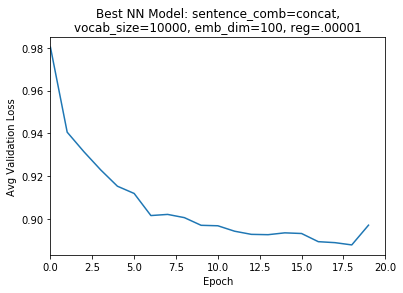

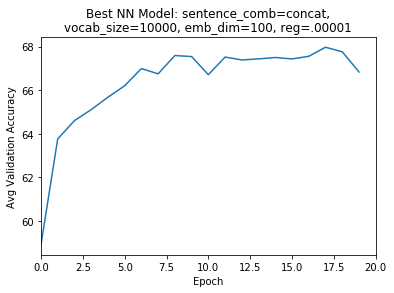

In [53]:
#create epoch vs. loss and acc plots for our best NN model
import matplotlib.pyplot as plt

#params used for this visual
#model_types=['NN']
#dataloader_list=[[train_loader,val_loader,vocab1+2]]
#dim_testsizes=[100]
#comb_methods=['concat']
#learning_rates = [0.01]
#optimizer_type=['Adam']
#l2_reg=[.00001]

#if we don't have the plotting data yet, create it
if not os.path.exists('NN_losslist.txt'):
    with open('NN_losslist.txt', 'w') as filehandle:
        filehandle.writelines("%s\n" % loss for loss in epoch_avgvalloss)
if not os.path.exists('NN_acclist.txt'):
    with open('NN_acclist.txt', 'w') as filehandle:
        filehandle.writelines("%s\n" % loss for loss in epoch_avgvalacc)

file1 = open("NN_losslist.txt","r")
file1=[float(i) for i in file1.read().split("\n")[0:20]]
file2 = open("NN_acclist.txt","r")
file2 = [float(i) for i in file2.read().split("\n")[0:20]]

plt.title("Best NN Model: sentence_comb=concat,\nvocab_size=10000, emb_dim=100, reg=.00001")
plt.xlabel("Epoch")
plt.ylabel("Avg Validation Loss")
plt.xlim(0,20)
plt.plot(file1)
plt.show()

plt.title("Best NN Model: sentence_comb=concat,\nvocab_size=10000, emb_dim=100, reg=.00001")
plt.xlabel("Epoch")
plt.ylabel("Avg Validation Accuracy")
plt.xlim(0,20)
plt.plot(file2)
plt.show()

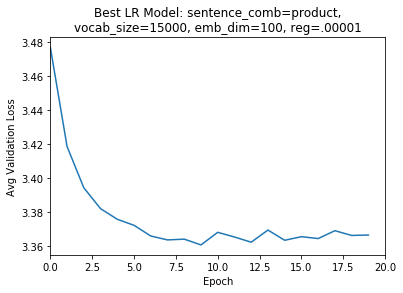

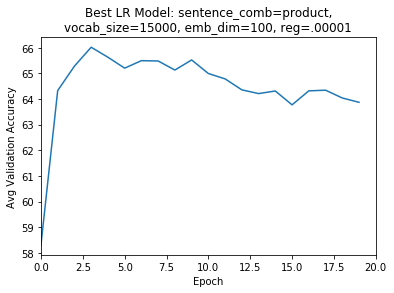

In [28]:
#create epoch vs. loss and acc plots for our best LR model
import matplotlib.pyplot as plt

#params used for this visual
#model_types=['LG']
#dataloader_list=[[train_loader_voc2,val_loader_voc2,vocab2+2]]
#dim_testsizes=[200]
#comb_methods=['product']
#learning_rates = [0.01]
#optimizer_type=['Adam']
#l2_reg=[.00001]

#if we don't have the plotting data yet, create it
if not os.path.exists('LR_losslist.txt'):
    with open('LR_losslist.txt', 'w') as filehandle:
        filehandle.writelines("%s\n" % loss for loss in epoch_avgvalloss)
if not os.path.exists('LR_acclist.txt'):
    with open('LR_acclist.txt', 'w') as filehandle:
        filehandle.writelines("%s\n" % loss for loss in epoch_avgvalacc)
        
file3 = open("LR_losslist.txt","r")
file3 = [float(i) for i in file3.read().split("\n")[0:20]]
file4 = open("LR_acclist.txt","r")
file4 = [float(i) for i in file4.read().split("\n")[0:20]]

plt.title("Best LR Model: sentence_comb=product,\nvocab_size=15000, emb_dim=100, reg=.00001")
plt.xlabel("Epoch")
plt.ylabel("Avg Validation Loss")
plt.xlim(0,20)
plt.plot(file3)
plt.show()

plt.title("Best LR Model: sentence_comb=product,\nvocab_size=15000, emb_dim=100, reg=.00001")
plt.xlabel("Epoch")
plt.ylabel("Avg Validation Accuracy")
plt.xlim(0,20)
plt.plot(file4)
plt.show()

In [31]:
#save our results to a CSV if we don't already have one
if not os.path.exists('results_table'):
    results_df.to_csv("results_table")
else:
    results_df=pd.read_csv("results_table",usecols=[1,3,4,5,6,7,8,9,10,11,12])

In [32]:
results_df.sort_values(by=['val_acc'],axis=0,ascending=False)

,model_type,sent_comb_method,vocab_size,embed_dim,optimizer,learning_rate,regularization,train_acc,val_acc,train_loss,val_loss
20,NN,concat,10000,100,Adam,0.01,0.00001,75.856,70.0,0.844871,0.997327
25,NN,product,15000,200,Adam,0.01,0.00001,83.245,68.2,0.728596,0.791601
24,NN,product,10000,200,Adam,0.01,0.00001,83.376,68.1,0.845691,0.877152
27,LG,product,15000,200,Adam,0.01,0.00001,81.902,67.6,3.215102,3.322199
21,NN,concat,15000,100,Adam,0.01,0.00001,76.151,67.1,0.862027,0.937692
17,NN,product,15000,100,Adam,0.01,0.00001,82.543,66.9,0.816725,1.056434
16,NN,product,10000,100,Adam,0.01,0.00001,81.222,66.7,0.827081,1.016528
28,NN,concat,10000,200,Adam,0.01,0.00001,74.578,66.7,0.852415,0.933229
4,NN,concat,10000,100,Adam,0.01,0.00000,91.102,66.7,0.652156,1.009378
19,LG,product,15000,100,Adam,0.01,0.00001,81.752,66.5,3.334356,3.305007


### Printing Correctly and Incorrectly Classified Sentences

In [30]:
def inverse_tokenize(sent):
    output = ''
    for word in sent:
        output += id2token_combined_sent[word]
        output += ' '
    return output

def six_classified_sentences(model_save_path):
    filler, model_type, combine_type, vocab_size, emb_dim, l2_reg = model_save_path.split('_')
    model=BagOfWords(int(vocab_size), int(emb_dim), combine_type, model_type)
    model.load_state_dict(torch.load(model_save_path))
    model.eval()
    
    misclassifieds = []
    classifieds = []
    
    #index = -1
    while len(misclassifieds) < 3 or len(classifieds) < 3:
        #index += 1
        index = np.random.randint(len(val_dataset))
        sent1, sent2, len1, len2, label = val_dataset[index]
        output = F.softmax(model(torch.tensor([sent1]), torch.tensor([sent2]), torch.tensor([len1]), torch.tensor([len2])))
        predicted = output.max(1, keepdim=True)[1]
        if int(predicted) != label and len(misclassifieds) < 3:
            misclassifieds.append([inverse_tokenize(sent1), inverse_tokenize(sent2), label, int(predicted), index])
        elif int(predicted) == label and len(classifieds) < 3:
            classifieds.append([inverse_tokenize(sent1), inverse_tokenize(sent2), label, int(predicted), index])
    return misclassifieds, classifieds

incorrect, correct = six_classified_sentences('v2_NN_concat_10002_100_1e-05')

print('The following three instances were classified incorrectly:')
print('#########################################################')
for instance in incorrect:
    sent1, sent2, true_label, pred_label, index = instance
    print('sentence 1: ', sent1)
    print('sentence 2: ', sent2)
    print('Real Label: ', le.inverse_transform([true_label])[0])
    print('Predicted Label: ', le.inverse_transform([pred_label])[0])
    print('')

print('')
print('')
print('The following three instances were classified correctly:')
print('#########################################################')
for instance in correct:
    sent1, sent2, true_label, pred_label, index = instance
    print('sentence 1: ', sent1)
    print('sentence 2: ', sent2)
    print('Real Label: ', le.inverse_transform([true_label])[0])
    print('Predicted Label: ', le.inverse_transform([pred_label])[0])
    print('')

The following three instances were classified incorrectly:
#########################################################
sentence 1:  a man is playing with a baby on a deck 
sentence 2:  a man plays with a dog 
Real Label:  contradiction
Predicted Label:  entailment

sentence 1:  a woman sitting in a tan chair beside of a dog while smiling at the camera 
sentence 2:  the man is an actor at a photoshoot 
Real Label:  contradiction
Predicted Label:  neutral

sentence 1:  a black man wearing a cap is sitting in a bus 
sentence 2:  a guy <unk> his <unk> before he starts his car 
Real Label:  contradiction
Predicted Label:  neutral



The following three instances were classified correctly:
#########################################################
sentence 1:  a west virginia university women 's basketball team officials and a small gathering of fans are in a west virginia arena 
sentence 2:  women are playing a big 12 conference game 
Real Label:  neutral
Predicted Label:  neutral

sentence 1:

/home/domingcd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


### 3.2

In [31]:
mnli_train_df = pd.read_csv('mnli_train.tsv', sep="\t")
mnli_val_df = pd.read_csv('mnli_val.tsv',sep="\t")

#Creates a list of genres represented in data
all_genres = []
for genre in mnli_train_df['genre']:
    if not genre in all_genres:
        all_genres.append(genre)

#similar to tokenize dataset function, but tokenizes with the pasted in vocab dictionary
def tokenize_with_vocab(dataset,vocab):
    output = []
    for sentence in dataset:
        tokens = tokenize(sentence)
        index_list = [vocab[token] if token in vocab.keys() else 1 for token in tokens]
        output.append(index_list)
        
    return output

#creates training datasets for each genre
for genre in all_genres:
    if not os.path.exists('val_sentence2_' +genre+'.p'):
        dataset = mnli_val_df.loc[mnli_val_df['genre'] == genre]
        sentence1_dataset = list(dataset['sentence1'])
        sentence2_dataset = list(dataset['sentence2'])
        val_sentence1 = tokenize_with_vocab(sentence1_dataset, token2id_combined_sent)
        val_sentence2 = tokenize_with_vocab(sentence2_dataset, token2id_combined_sent)
        pkl.dump(val_sentence1, open("val_sentence1_" + genre +".p", "wb"))
        pkl.dump(val_sentence2, open("val_sentence2_" + genre +".p", "wb"))
            
val_sentence1_telephone = pkl.load(open("val_sentence1_telephone.p", "rb"))
val_sentence2_telephone = pkl.load(open("val_sentence2_telephone.p", "rb"))
val_sentence1_fiction = pkl.load(open("val_sentence1_fiction.p", "rb"))
val_sentence2_fiction = pkl.load(open("val_sentence2_fiction.p", "rb"))
val_sentence1_slate = pkl.load(open("val_sentence1_slate.p", "rb"))
val_sentence2_slate = pkl.load(open("val_sentence2_slate.p", "rb"))
val_sentence1_government = pkl.load(open("val_sentence1_government.p", "rb"))
val_sentence2_government = pkl.load(open("val_sentence2_government.p", "rb"))
val_sentence1_travel = pkl.load(open("val_sentence1_travel.p", "rb"))
val_sentence2_travel = pkl.load(open("val_sentence2_travel.p", "rb"))

#intializes lists for the label
telephone_label = list(le.transform(mnli_val_df.loc[mnli_val_df['genre'] == 'telephone']['label']))
fiction_label = list(le.transform(mnli_val_df.loc[mnli_val_df['genre'] == 'fiction']['label']))
slate_label = list(le.transform(mnli_val_df.loc[mnli_val_df['genre'] == 'slate']['label']))
government_label = list(le.transform(mnli_val_df.loc[mnli_val_df['genre'] == 'government']['label']))
travel_label = list(le.transform(mnli_val_df.loc[mnli_val_df['genre'] == 'travel']['label']))


#sets up loaders to pass into test_model function
val_dataset_telephone = NewsGroupDataset(val_sentence1_telephone,val_sentence2_telephone, telephone_label, 35)
val_dataset_fiction = NewsGroupDataset(val_sentence1_fiction,val_sentence2_fiction, fiction_label, 35)
val_dataset_slate = NewsGroupDataset(val_sentence1_slate,val_sentence2_slate, slate_label, 35)
val_dataset_government = NewsGroupDataset(val_sentence1_government,val_sentence2_government, government_label, 35)
val_dataset_travel = NewsGroupDataset(val_sentence1_travel,val_sentence2_travel, travel_label, 35)

telephone_loader = torch.utils.data.DataLoader(dataset=val_dataset_telephone, 
                                        batch_size=32,
                                        collate_fn=newsgroup_collate_func,
                                        shuffle=True)

fiction_loader = torch.utils.data.DataLoader(dataset=val_dataset_fiction, 
                                        batch_size=32,
                                        collate_fn=newsgroup_collate_func,
                                        shuffle=True)

slate_loader = torch.utils.data.DataLoader(dataset=val_dataset_slate, 
                                        batch_size=32,
                                        collate_fn=newsgroup_collate_func,
                                        shuffle=True)

government_loader = torch.utils.data.DataLoader(dataset=val_dataset_government, 
                                        batch_size=32,
                                        collate_fn=newsgroup_collate_func,
                                        shuffle=True)

travel_loader = torch.utils.data.DataLoader(dataset=val_dataset_travel, 
                                        batch_size=32,
                                        collate_fn=newsgroup_collate_func,
                                        shuffle=True)

In [32]:
def section_3point2(model_save_path):
    filler, model_type, combine_type, vocab_size, emb_dim, l2_reg = model_save_path.split('_')
    model=BagOfWords(int(vocab_size), int(emb_dim), combine_type, model_type)
    model.load_state_dict(torch.load(model_save_path))
    
    telephone_accuracy = test_model(telephone_loader, model)[0]
    fiction_accuracy = test_model(fiction_loader, model)[0]
    slate_accuracy = test_model(slate_loader, model)[0]
    government_accuracy = test_model(government_loader, model)[0]
    travel_accuracy = test_model(travel_loader, model)[0]
    
    return pd.DataFrame({'telephone accuracy':[telephone_accuracy], 'fiction accuracy': [fiction_accuracy], 
            'slate accuracy': [slate_accuracy], 'government accuracy': [government_accuracy], 'travel accuracy':[travel_accuracy]})

best_LG_model_path = 'v2_LG_product_15002_200_1e-05'
best_NN_model_path = 'v2_NN_concat_10002_100_1e-05'

LG_genre_df = pd.DataFrame(section_3point2(best_LG_model_path))
NN_genre_df = pd.DataFrame(section_3point2(best_NN_model_path))

table_3point2 = pd.concat([LG_genre_df, NN_genre_df])
table_3point2['Model Type'] = ['LG', 'NN']
table_3point2 = table_3point2[table_3point2.columns[-1:].tolist() + table_3point2.columns[:-1].tolist()]
table_3point2

,Model Type,telephone accuracy,fiction accuracy,slate accuracy,government accuracy,travel accuracy
0,LG,38.905473,40.201005,38.922156,36.909449,37.474542
0,NN,44.278607,41.809045,40.518962,37.598425,38.492872


### 3.3

In [33]:
#creates training datasets for each genre
for genre in all_genres:
    if not os.path.exists('train_sentence2_' +genre+'.p'):
        dataset = mnli_train_df.loc[mnli_train_df['genre'] == genre]
        sentence1_dataset = list(dataset['sentence1'])
        sentence2_dataset = list(dataset['sentence2'])
        train_sentence1 = tokenize_with_vocab(sentence1_dataset, token2id_combined_sent)
        train_sentence2 = tokenize_with_vocab(sentence2_dataset, token2id_combined_sent)
        pkl.dump(train_sentence1, open("train_sentence1_" + genre +".p", "wb"))
        pkl.dump(train_sentence2, open("train_sentence2_" + genre +".p", "wb"))
        
print('pickle files saved')
            
train_sentence1_telephone = pkl.load(open("train_sentence1_telephone.p", "rb"))
train_sentence2_telephone = pkl.load(open("train_sentence2_telephone.p", "rb"))
train_sentence1_fiction = pkl.load(open("train_sentence1_fiction.p", "rb"))
train_sentence2_fiction = pkl.load(open("train_sentence2_fiction.p", "rb"))
train_sentence1_slate = pkl.load(open("train_sentence1_slate.p", "rb"))
train_sentence2_slate = pkl.load(open("train_sentence2_slate.p", "rb"))
train_sentence1_government = pkl.load(open("train_sentence1_government.p", "rb"))
train_sentence2_government = pkl.load(open("train_sentence2_government.p", "rb"))
train_sentence1_travel = pkl.load(open("train_sentence1_travel.p", "rb"))
train_sentence2_travel = pkl.load(open("train_sentence2_travel.p", "rb"))

#intializes lists for the label
telephone_train_label = list(le.transform(mnli_train_df.loc[mnli_train_df['genre'] == 'telephone']['label']))
fiction_train_label = list(le.transform(mnli_train_df.loc[mnli_train_df['genre'] == 'fiction']['label']))
slate_train_label = list(le.transform(mnli_train_df.loc[mnli_train_df['genre'] == 'slate']['label']))
government_train_label = list(le.transform(mnli_train_df.loc[mnli_train_df['genre'] == 'government']['label']))
travel_train_label = list(le.transform(mnli_train_df.loc[mnli_train_df['genre'] == 'travel']['label']))


#sets up loaders to pass into test_model function
train_dataset_telephone = NewsGroupDataset(train_sentence1_telephone,train_sentence2_telephone, telephone_train_label, 35)
train_dataset_fiction = NewsGroupDataset(train_sentence1_fiction,train_sentence2_fiction, fiction_train_label, 35)
train_dataset_slate = NewsGroupDataset(train_sentence1_slate,train_sentence2_slate, slate_train_label, 35)
train_dataset_government = NewsGroupDataset(train_sentence1_government,train_sentence2_government, government_train_label, 35)
train_dataset_travel = NewsGroupDataset(train_sentence1_travel,train_sentence2_travel, travel_train_label, 35)

telephone_train_loader = torch.utils.data.DataLoader(dataset=train_dataset_telephone, 
                                        batch_size=32,
                                        collate_fn=newsgroup_collate_func,
                                        shuffle=True)

fiction_train_loader = torch.utils.data.DataLoader(dataset=train_dataset_fiction, 
                                        batch_size=32,
                                        collate_fn=newsgroup_collate_func,
                                        shuffle=True)

slate_train_loader = torch.utils.data.DataLoader(dataset=train_dataset_slate, 
                                        batch_size=32,
                                        collate_fn=newsgroup_collate_func,
                                        shuffle=True)

government_train_loader = torch.utils.data.DataLoader(dataset=train_dataset_government, 
                                        batch_size=32,
                                        collate_fn=newsgroup_collate_func,
                                        shuffle=True)

travel_train_loader = torch.utils.data.DataLoader(dataset=train_dataset_travel, 
                                        batch_size=32,
                                        collate_fn=newsgroup_collate_func,
                                        shuffle=True)

pickle files saved


In [34]:
#create pandas DF to store results
genre_df=pd.DataFrame(columns=['genre','acc_no_fineTuning','acc_with_fineTuning','telephoneModel_acc',\
 'fictionModel_acc','slateModel_acc','governmentModel_acc','travelModel_acc'])
genre_df

,genre,acc_no_fineTuning,acc_with_fineTuning,telephoneModel_acc,fictionModel_acc,slateModel_acc,governmentModel_acc,travelModel_acc


In [33]:
#Loading model
filler, model_type, combine_type, vocab_size, emb_dim, l2_reg = 'v2_NN_concat_10002_100_1e-05'.split('_')
vocab_size = int(vocab_size)
emb_dim = int(emb_dim)
l2_reg = float(l2_reg)

num_epochs = 20
loaders = [[telephone_train_loader,telephone_loader,vocab2+2, 'telephone'], [fiction_train_loader,fiction_loader,vocab2+2, 'fiction'], 
           [slate_train_loader, slate_loader, vocab2+2, 'slate'], [government_train_loader, government_loader, vocab2+2, 'government'], 
           [travel_train_loader, travel_loader, vocab2+2, 'travel']]

#save the model names
save_strs=[]

for loader in loaders:
    save_str=('mnli_v2_'+loader[3]+model_type+'_'+combine_type+'_'+str(vocab_size)+'_'+str(emb_dim)+'_'+str(l2_reg).replace('0.',''))
    save_strs.append(save_str)
    model=BagOfWords(vocab_size, emb_dim, combine_type, model_type)
    
    if not os.path.exists(save_str):
        model.load_state_dict(torch.load('v2_NN_concat_10002_100_1e-05'))
        optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)
        epoch_models=[]
        for epoch in range(num_epochs):
            for i, (data1, data2, lengths1, lengths2, labels) in enumerate(loader[0]):
                model.train()
                data_batch1, data_batch2, length_batch1, length_batch2, label_batch = data1, data2, lengths1, lengths2, labels
                optimizer.zero_grad()
                outputs = model(data_batch1, data_batch2, length_batch1, length_batch2)
                loss = criterion(outputs, label_batch)
                loss.backward()
                optimizer.step()
                # validate every x iterations
                if i > 0 and i % 119 == 0:
                    'happened'
                    # validate
                    val_acc = test_model(loader[1], model)[0]
                    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                        epoch+1, num_epochs, i+1, len(loader[0]), val_acc))
            #here we have finished the epoch, so save our results
            epoch_models.append([epoch,model,test_model(loader[1], model)[0]])
        
        #print(epoch_models)
        #here all epochs have run, so we want to save only the model with the best val accuracy
        max_acc=max([i[2] for i in epoch_models])
        print(loader[3], max_acc)
        max_indx=[i[2] for i in epoch_models].index(max_acc)
        model=epoch_models[max_indx][1]
        
        #now save the model so we don't have to rerun
        torch.save(model.state_dict(),save_str)
        
        #add max result to df
        genre_df=genre_df.append(pd.Series([loader[3],'',max_acc,'','','','',''],index=genre_df.columns),ignore_index=True)
        
    else:
        model.load_state_dict(torch.load(save_str))
        #now add loaded results to df
        genre_df=genre_df.append(pd.Series([loader[3],'',test_model(loader[1], model)[0],'','','','',''],index=genre_df.columns),ignore_index=True)

In [34]:
#now add the results without fine tuning so we can compare to result with fine tuning
counter=0
for genre in all_genres:
    colname=genre+' accuracy'
    genre_df.at[counter,'acc_no_fineTuning']=table_3point2.at[0,colname][1]
    counter+=1

In [35]:
telephone_model = BagOfWords(10000+2, 100, 'concat', 'NN')
fiction_model = BagOfWords(10000+2, 100, 'concat', 'NN')
slate_model = BagOfWords(10000+2, 100, 'concat', 'NN')
government_model = BagOfWords(10000+2, 100, 'concat', 'NN')
travel_model = BagOfWords(10000+2, 100, 'concat', 'NN')

telephone_model.load_state_dict(torch.load(save_strs[0]))
fiction_model.load_state_dict(torch.load(save_strs[1]))
slate_model.load_state_dict(torch.load(save_strs[2]))
government_model.load_state_dict(torch.load(save_strs[3]))
travel_model.load_state_dict(torch.load(save_strs[4]))

model_list=[[telephone_model,'telephone'],[fiction_model,'fiction'],[slate_model,'slate'],[government_model,'government'],[travel_model,'travel']]

for model in model_list:
    for loader in loaders:
        val_acc=test_model(loader[1],model[0])[0]
        if model[1]!=loader[3]:
            #print("Accuracy of "+model[1]+" model on "+loader[3]+" data is: "+str(val_acc))
            genre_df.at[genre_df.loc[genre_df['genre']==loader[3]].index[0],model[1]+'Model_acc']=val_acc
        else:
            genre_df.at[genre_df.loc[genre_df['genre']==loader[3]].index[0],model[1]+'Model_acc']='N/A'

In [36]:
genre_df

,genre,acc_no_fineTuning,acc_with_fineTuning,telephoneModel_acc,fictionModel_acc,slateModel_acc,governmentModel_acc,travelModel_acc
0,telephone,44.2786,49.751244,N/A,45.9701,44.7761,46.3682,48.2587
1,fiction,41.809,46.834171,45.9296,N/A,44.5226,44.3216,44.2211
2,slate,40.519,42.215569,46.7066,40.1198,N/A,44.6108,42.2156
3,government,37.5984,51.279528,47.7362,43.7992,44.8819,N/A,48.4252
4,travel,38.4929,48.268839,41.1405,44.6029,42.8717,45.3157,N/A


### 3.5

In [69]:
#load the best models per model type and get their word embeddings
best_NN_model=BagOfWords(10002, 100, 'concat', 'NN')    
best_NN_model.load_state_dict(torch.load('v2_NN_concat_10002_100_1e-05'))
NN_embedding=next(best_NN_model.parameters())
NN_embedding=NN_embedding.detach().numpy()

best_LR_model=BagOfWords(15002, 200, 'product', 'LG')    
best_LR_model.load_state_dict(torch.load('v2_LG_product_15002_200_1e-05'))
LR_embedding=next(best_LR_model.parameters())
LR_embedding=LR_embedding.detach().numpy()

In [ ]:
#if you already have top word similarities, don't rerun them
#takes ~20-30 mins per model type to run if you don't have similarity file

#Generate & save word similarities for best NN model
if not os.path.exists('NN_similarity.txt'):
    #create 
    top_ct=50
    #create list to hold word distances and index 
    eucdist_list_NN=[]

    #compare each word to one another using Euclidean distance, skipping padding and unknown indices
    for i in range(2,NN_embedding.shape[0]):
        for j in range(i,NN_embedding.shape[0]):
            #don't compute similarity for identical words
            if i!=j:
                word1=NN_embedding[i]
                word2=NN_embedding[j]
                #slow to compute, don't use
                #euc_dist=math.sqrt(sum([(a - b) ** 2 for a, b in zip(word1, word2)]))
                euc_dist=np.linalg.norm(word1-word2)
                #save the two words and their similarity to a list so we can find most similar later
                eucdist_list_NN.append([euc_dist,i,j])
        if i % 500==0:
            print("Finished Word: "+str(i)+" of 10,000")

    print("Now Sorting NN List")
    #sort list by word similarity ASC as most similar word pairs = lowest Euclidean distance,
    eucdist_list_NN=sorted(eucdist_list_NN,key=lambda l:l[0])
    print("Finished Sorting NN List")
    
    #now save the most similar words
    with open('NN_similarity.txt', 'w') as filehandle:
        filehandle.writelines("%s\n" % similarity for similarity in eucdist_list_NN[0:top_ct])
        
#Generate & save word similarities for best LR model
if not os.path.exists('LR_similarity.txt'):
    #create 
    top_ct=50
    #create list to hold word distances and index 
    eucdist_list_LR=[]

    #compare each word to one another using Euclidean distance, skipping padding and unknown indices
    for i in range(2,LR_embedding.shape[0]):
        for j in range(i,LR_embedding.shape[0]):
            #don't compute similarity for identical words
            if i!=j:
                word1=LR_embedding[i]
                word2=LR_embedding[j]
                #slow to compute, don't use
                #euc_dist=math.sqrt(sum([(a - b) ** 2 for a, b in zip(word1, word2)]))
                euc_dist=np.linalg.norm(word1-word2)
                #save the two words and their similarity to a list so we can find most similar later
                eucdist_list_LR.append([euc_dist,i,j])
        if i % 500==0:
            print("Finished Word: "+str(i)+" of 15,000")

    print("Now Sorting LR List")
    #sort list by word similarity ASC as most similar word pairs = lowest Euclidean distance,
    eucdist_list_LR=sorted(eucdist_list_LR,key=lambda l:l[0])
    print("Finished Sorting LR List")
    
    #now save the most similar words
    with open('LR_similarity.txt', 'w') as filehandle:
        filehandle.writelines("%s\n" % similarity for similarity in eucdist_list_LR[0:top_ct])

Finished Word: 500 of 15,000


In [66]:
#At this point top word pairings have been saved, so load and print most similar word pairs
with open("NN_similarity.txt","r") as textFile:
    file_sim=[line.replace("[","").replace("]","").replace(",","").split() for line in textFile]

for i in range(len(file_sim)):
    file_sim[i][0]=float(file_sim[i][0])
    file_sim[i][1]=int(file_sim[i][1])
    file_sim[i][2]=int(file_sim[i][2])

print("10 Most Similar Word Pairings for NN Model:")
#print the top word similarities
for i in range(17):
    #Many top pairings have same score, so grab pairs that are easiest to discuss for report
    if i not in([3,4,9,10,12,14,15]):
        print(inverse_tokenize([file_sim[i][1]])+", "+\
              inverse_tokenize([file_sim[i][2]])+" with distance "+str(file_sim[i][0]))

10 Most Similar Word Pairings for NN Model:
walkie , talkie  with distance 0.0
calvin , klein  with distance 0.0
oscar , grouch  with distance 0.0
michael , jackson  with distance 0.0
melky , cabrera  with distance 0.0
wells , fargo  with distance 0.0
kung , fu  with distance 0.0
avril , lavigne  with distance 0.0
plated , entree  with distance 0.0
terra , cotta  with distance 0.0
